In [ ]:
import pandas
import neattext as nt
import numpy as np
import transformers
import pyarrow as pa
import torch
import math

from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


In [ ]:
emotions_dictionary = {'sadness': 0, 'joy': 1, 'anger': 2, 'fear': 3, 'surprise': 4} 
emotions_dictionary_inverted = {0: 'sadness', 1: 'joy', 2: 'anger', 3: 'fear', 4: 'surprise'}

## First dataset: https://huggingface.co/datasets/dair-ai/emotion

In [ ]:
dataset = load_dataset('emotion')
dataset.set_format(type="pandas")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_df = dataset['train'][:]
valid_df = dataset['validation'][:]
test_df  = dataset['test'][:]

In [ ]:
joint_dataset = pandas.concat([train_df, valid_df, test_df])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
joint_dataset['label'] = joint_dataset['label'].replace(0, value='sadness')
joint_dataset['label'] = joint_dataset['label'].replace(1, value='joy')
joint_dataset['label'] = joint_dataset['label'].replace(2, value='love')
joint_dataset['label'] = joint_dataset['label'].replace(3, value='anger')
joint_dataset['label'] = joint_dataset['label'].replace(4, value='fear')
joint_dataset['label'] = joint_dataset['label'].replace(5, value='surprise')

joint_dataset = joint_dataset[joint_dataset['label'] != 'love']

In [ ]:
joint_dataset['label'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
surprise     719
Name: label, dtype: int64

# Second dataset: google dataset

In [ ]:
second_dataset = pandas.read_csv('google_dataset.csv')
second_dataset = second_dataset[second_dataset['example_very_unclear'] == False]

In [ ]:
# Not let's resize the number of columns in the dataset. We only need 'text', 'label'. Before doin that, we first have
# to assign an emotion to each tweet seeing which bit is set to '1' in the related column. Let's define a function that 
# is able to manage this problem:

FULL_LIST_OF_EMOTIONS = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire','disappointment', 'disapproval', 'disgust',
                'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
                'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
                'surprise','neutral'
               ]

def get_emotion_description_from_row(list_of_bits) -> str:
    """
    Assigns an emotion to each tweet contained into the dataset. 
    
    Accepts:
        The list of bits that represents the emotion assigned to a text
    
    Returns:
        The string that represents emotion assigned to the text taken as input.
    """
    position_of_first_one =  list_of_bits.values.tolist().index(1)
    return FULL_LIST_OF_EMOTIONS[position_of_first_one]
    
    
# Assign emotion to each row
second_dataset['label'] = second_dataset.apply(lambda row: get_emotion_description_from_row(row[FULL_LIST_OF_EMOTIONS]) ,axis=1)

In [ ]:
second_dataset['label'].value_counts()

neutral           55207
admiration        17129
approval          15520
annoyance         11925
disapproval        8909
amusement          8858
gratitude          8432
anger              7943
curiosity          7703
disappointment     6768
confusion          6599
love               5306
caring             5146
realization        5123
joy                5118
optimism           4992
excitement         4374
sadness            3859
surprise           3471
disgust            3419
desire             2999
fear               2510
embarrassment      1720
remorse            1648
nervousness         945
relief              812
pride               714
grief               494
Name: label, dtype: int64

In [ ]:
LIST_OF_EMOTIONS_TO_KEEP = ['joy', 'anger', 'fear', 'sadness','surprise']

second_dataset = second_dataset[second_dataset["label"].isin(LIST_OF_EMOTIONS_TO_KEEP)]


In [ ]:
# Now let's keep only the columns we are intrested in 
second_dataset = second_dataset.filter(items=['text', 'label'])
second_dataset.head(3)

,text,label
0,That game hurt.,sadness
43,By far the coolest thing I've seen on this thr...,joy
49,Sending love and strength vibes <3,joy


<Axes: >

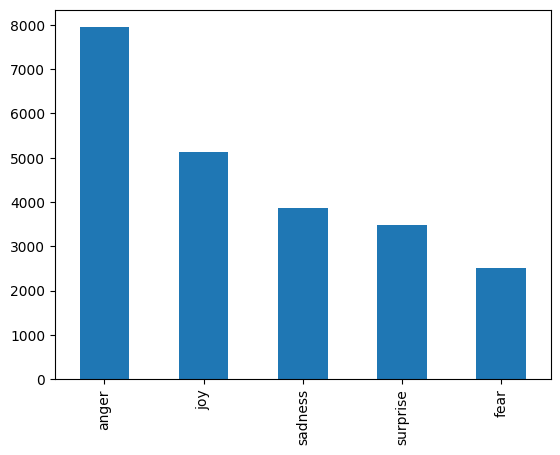

In [ ]:
second_dataset["label"].value_counts().plot(kind='bar')

In [ ]:
second_dataset['label'].value_counts()

anger       7943
joy         5118
sadness     3859
surprise    3471
fear        2510
Name: label, dtype: int64

In [ ]:
second_dataset.head(5)

,text,label
0,That game hurt.,sadness
43,By far the coolest thing I've seen on this thr...,joy
49,Sending love and strength vibes <3,joy
58,Me too! First time in a couple of years!,joy
60,Ironic. He could save others from secrecy-enab...,surprise


# Join datasets

In [ ]:
final_dataset = pandas.concat([joint_dataset, second_dataset], axis=0)

In [ ]:
final_dataset['label'].value_counts()

joy         11879
anger       10652
sadness      9656
fear         4883
surprise     4190
Name: label, dtype: int64

In [ ]:
final_dataset['label'] = final_dataset['label'].replace(regex='sadness', value=0)
final_dataset['label'] = final_dataset['label'].replace(regex='joy', value=1)
final_dataset['label'] = final_dataset['label'].replace(regex='anger', value=2)
final_dataset['label'] = final_dataset['label'].replace(regex='fear', value=3)
final_dataset['label'] = final_dataset['label'].replace(regex='surprise', value=4)

In [ ]:
final_dataset['label'].value_counts()

1    11879
2    10652
0     9656
3     4883
4     4190
Name: label, dtype: int64

In [ ]:
train_df, valid_df, test_df = np.split(
    final_dataset.sample(frac=1, random_state=42), 
    [int(.8*len(final_dataset)), int(.9*len(final_dataset))])

In [ ]:
train_df['label'].value_counts()

1    9520
2    8485
0    7705
3    3942
4    3356
Name: label, dtype: int64

In [ ]:
valid_df['label'].value_counts()

1    1186
2    1053
0     990
3     469
4     428
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

1    1173
2    1114
0     961
3     472
4     406
Name: label, dtype: int64

# Undersampling

<Axes: >

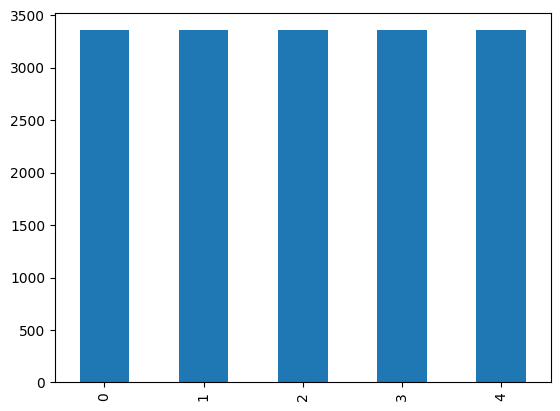

In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(n=min(3356, len(x))))
train_df['label'].value_counts().plot(kind='bar')

In [ ]:
train_df['label'].value_counts()

0    3356
1    3356
2    3356
3    3356
4    3356
Name: label, dtype: int64

# Multiclass classification with BERT
At this point 3 datasets are available: \\
1. train_df = dataset containing data for training
2. valid_df = dataset containing data for validation
3. train_df = dataset containing data for test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Light text preprocessing

In [ ]:
# Keeping hashtags as they can be important for the emotion recognition.

def preprocess_data(text):
    text = text.replace("[NAME]", "")
    text = text.replace("[RELIGION]", "")
    docx = nt.TextFrame(text=text)
    text = docx.remove_urls()
    text = docx.remove_dates()
    text = docx.remove_numbers()
    text = docx.remove_html_tags()
    text = docx.remove_emojis()
    text = docx.remove_special_characters()
    return docx.text

In [ ]:
train_df['text'] = train_df['text'].apply(lambda text: preprocess_data(text))
valid_df['text'] = valid_df['text'].apply(lambda text: preprocess_data(text))
test_df['text'] = test_df['text'].apply(lambda text: preprocess_data(text))

In [ ]:
# Because BERT is a language model that utilises the structure of the sentence from both directions to connect every output element to every 
# input element, and dynamically adjust weightings depending on this connection (this process is called attention), my hypothesis is that 
# the lighter pre-processing will do better. This is because stopwords and other grammatical features of sentences may have a part to play 
# in helping the model’s attention.

def process_data(rows):
    processed_rows = tokenizer.batch_encode_plus(
        rows,
        add_special_tokens=True,
        max_length = 128,
        padding = 'max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = processed_rows['input_ids']
    attention_masks = processed_rows['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = process_data(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = process_data(valid_df['text'].values.tolist())
test_input_ids, test_att_masks   = process_data(test_df['text'].values.tolist())

In [ ]:
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())

In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 5,
    output_attentions = False,
    output_hidden_states = False
    )


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [ ]:
EPOCHS = 12

optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader)*EPOCHS 
    )

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))




Epoch:  1


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 1.4964280260176885 
129/129 val loss: 1.238252695216689 
Epoch:  2


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 1.110837112267812 
129/129 val loss: 0.8916180914686632 
Epoch:  3


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.8318172777834393 
129/129 val loss: 0.7386042203089987 
Epoch:  4


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.7093821901366825 
129/129 val loss: 0.692601871467376 
Epoch:  5


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.6421058901151021 
129/129 val loss: 0.6591416382512381 
Epoch:  6


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5990293024267469 
129/129 val loss: 0.6291810730400011 
Epoch:  7


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5661834755965641 
129/129 val loss: 0.6152491047400837 
Epoch:  8


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5428256286325909 
129/129 val loss: 0.6068545192942139 
Epoch:  9


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5299501629386629 
129/129 val loss: 0.603070068035939 
Epoch:  10


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5138916730880737 
129/129 val loss: 0.5948191637447638 
Epoch:  11


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5021525540805998 
129/129 val loss: 0.5941951345334682 
Epoch:  12


Training:   0%|          | 0/525 [00:00<?, ?it/s]

Validation:   0%|          | 0/129 [00:00<?, ?it/s]

525/525 train loss: 0.5000867332447143 
129/129 val loss: 0.5957961556061294 


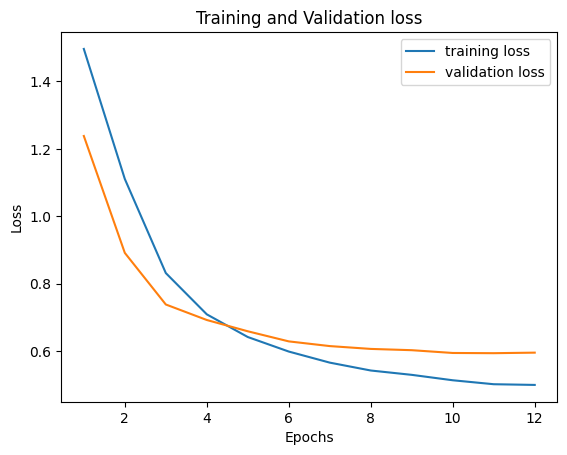

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
print('classifiation report')
print(classification_report(
    valid_df['label'].to_numpy(),
    valid_pred,
    target_names= list(emotions_dictionary.keys()) 
     )
)

classifiation report
              precision    recall  f1-score   support

     sadness       0.84      0.78      0.81       990
         joy       0.91      0.85      0.88      1186
       anger       0.82      0.78      0.80      1053
        fear       0.70      0.83      0.76       469
    surprise       0.64      0.78      0.70       428

    accuracy                           0.81      4126
   macro avg       0.78      0.81      0.79      4126
weighted avg       0.82      0.81      0.81      4126



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

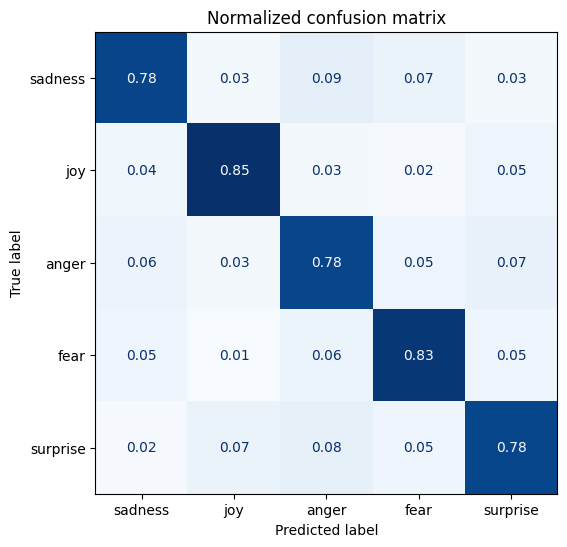

In [ ]:
plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=list(emotions_dictionary.keys()))


In [ ]:
model.save_pretrained('./model/')


In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=list(emotions_dictionary.keys())))


classifiation report
              precision    recall  f1-score   support

     sadness       0.80      0.84      0.82       919
         joy       0.84      0.92      0.88      1069
       anger       0.80      0.82      0.81      1085
        fear       0.80      0.70      0.75       543
    surprise       0.79      0.63      0.70       510

    accuracy                           0.81      4126
   macro avg       0.81      0.78      0.79      4126
weighted avg       0.81      0.81      0.81      4126



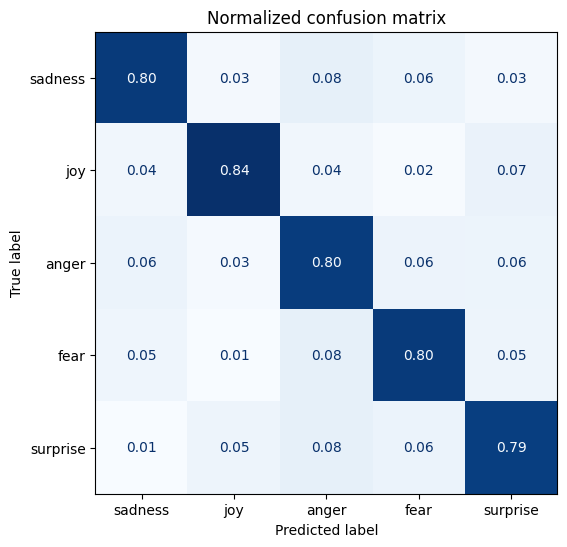

In [ ]:
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=list(emotions_dictionary.keys()))


In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)

error_df = test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)
error_df['label'] = error_df['label'].replace(0, 'sadness')
error_df['label'] = error_df['label'].replace(1, 'joy')
error_df['label'] = error_df['label'].replace(2, 'anger')
error_df['label'] = error_df['label'].replace(3, 'fear')
error_df['label'] = error_df['label'].replace(4, 'surprise')
error_df['pred'] = error_df['pred'].replace(0, 'sadness')
error_df['pred'] = error_df['pred'].replace(1, 'joy')
error_df['pred'] = error_df['pred'].replace(2, 'anger')
error_df['pred'] = error_df['pred'].replace(3, 'fear')
error_df['pred'] = error_df['pred'].replace(4, 'surprise')

In [ ]:
error_df

,text,label,pred
2300,i feel very agitated and sort of lost,anger,fear
18229,They come to your house and rob you at gun poi...,fear,anger
209777,To each according to their needs Except entitl...,sadness,anger
53511,Company car Oh boy hes in trouble now,surprise,fear
8673,i remember feeling so helpless i had been a mo...,sadness,fear
172748,Uh Uh Im not feeling so well,sadness,joy
38944,This was potentially the most dangerous stunt ...,surprise,fear
122091,Dragon bender has even more negative value tha...,sadness,anger
141920,Omfg the worst want to pull my hair out,surprise,fear
5468,If this team could make there wide open shots ...,joy,surprise


In [ ]:
from transformers import AutoModelForSequenceClassification

new_model = AutoModelForSequenceClassification.from_pretrained('/content/model')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
np.argmax(output.logits.cpu().detach().numpy(),axis=-1)

array([5])

In [ ]:
output.logits.cpu().detach().numpy()

array([[-1.398998  , -0.66739255, -2.373522  ,  1.5816537 ,  1.2257417 ,
         1.6552818 ]], dtype=float32)

In [ ]:
from collections import defaultdict

conversations = []

def clean_text(text):
  text = text.replace("\ ", '')
  text = text.replace('-', ' ')
  text = text.replace(' / ', '')
  return text


with open('/content/conversations.txt', 'r') as file:
  for line in file.readlines():
    line = line.split('+')
    line = [x for x in line if x != ' \n']
    
    conversation_data = []
    
    for index in range(0, len(line)-1, 2):
      conversation_data.append((line[index], clean_text(line[index+1])))  
    conversations.append(conversation_data)
  file.close()

In [ ]:
conversations[0]

[('WILL ',
  '  Did you buy all these books retail, or do you send away for like a "shrink kit" that comes with all these volumes included? '),
 (' SEAN ', '  Have you read all these books, Will? '),
 (' WILL ', '  Probably not. '),
 (' SEAN ', '  How about the ones on that shelf? ')]

In [ ]:
conversation_emotions = []

for conversation in conversations:
  for character,utterance in conversation:
    utterance_to_predict = preprocess_data(utterance)
    input_ids, att_masks = process_data([utterance_to_predict])
    output = new_model(input_ids = input_ids, attention_mask=att_masks)
    prediction = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
    confidence = torch.max(softmax(output.logits))
    print(utterance)

    if confidence > 0.66:
      print(emotions_dictionary_inverted[prediction[0]])
    else:
      print("NETRUAL")
  print('\n\n\n')
    
        

<ipython-input-28-c396ba013cb8>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence = torch.max(softmax(output.logits))


  Did you buy all these books retail, or do you send away for like a "shrink kit" that comes with all these volumes included? 
surprise
  Have you read all these books, Will? 
surprise
  Probably not. 
NETRUAL
  How about the ones on that shelf? 
surprise




  Yeah, I read those. 
surprise
  What did you think? 
surprise
  I'm not here for a fuckin' book report. They're your books, why don't you read 'em? 
anger
  I did. 
NETRUAL
  That must have taken you a long time. 
NETRUAL
  Yeah, it did take me a long time. 
NETRUAL




  "A History of the United States, Volume I." If you want to read a real history book, read Howard Zinn's "A People's History of the United States." That book will knock you on your ass. 
anger
  How about Noam Chomsky's "Manufacturing Consent?" 
surprise
  You people baffle me. You spend all this money on beautiful, fancy books   and they're the wrong fuckin' books. 
anger
  You think so? 
surprise
  Whatever blows your hair back. 
anger




  Guy your age shoul

In [ ]:
from torch.nn.functional import softmax

utterance = 'Yeah, it did take me a long time. '
utterance_to_predict = preprocess_data(utterance)
input_ids, att_masks = process_data([utterance_to_predict])
output = new_model(input_ids = input_ids, attention_mask=att_masks)
logits = output.logits
prediction = np.argmax(logits.cpu().detach().numpy(),axis=-1)
print(utterance)
print(emotions_dictionary_inverted[prediction[0]])
print(max(output.logits.cpu().detach().numpy()))
print(torch.max(softmax(logits)))


Yeah, it did take me a long time. 
surprise
[ 0.5949796   0.00416179 -1.2069198   0.1481785   0.67333066]
tensor(0.3144, grad_fn=<MaxBackward1>)


<ipython-input-20-42d5464a49ba>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.max(softmax(logits)))
